# LIDAR ponthalmaz regisztrációja kvaterniókkal

[Yan-Bin Jia (2022)](https://faculty.sites.iastate.edu/jia/files/inline-files/quaternion.pdf) és [Shen et al. (2006)](https://link.springer.com/article/10.1007/s00190-006-0054-8) nyomán [Wang et al. (2014)](http://dx.doi.org/10.1016/j.isprsjprs.2014.04.013) cikkében található LIDAR-os adatok regisztrációját (illesztését) végezzük el kvaterniókkal.

Az illesztendő adatok a $p_i$ pontok, a referencia pontok pedig a $q_i$ pontok.

<div>
<img src="figs/Jia_fig_3.png" width="600"/>
</div>


Az algoritmus a következő lépésekből áll:

1. A súlypontra vonatkozó koordináták számítása
2. Az $M$ mátrix számítása 
3. Az $M$ mátrix sajátértékeinek és sajátvektorainak számítása. Az $M$ mátrix sajátvektorához tartozó maximális sajátérték a $q$ forgatási kvaternió megoldása
4. A forgatási mátrix számítása
5. $k$ méretarány paraméter számítása
6. $t$ eltolás paraméter számítása

A kvaterniókkal kapcsolatos műveletek közül a forgatási mátrix számítására van szükség. Ehhez a Kevin Walchko által írt egyszerű [`squaternion`](https://github.com/MomsFriendlyRobotCompany/squaternion) könyvtárat használjuk.

Beolvassuk és kirajzoljuk az [adatokat](lidar.dat):
    
<div>
<img src="figs/lidar.png" width="600"/>
</div>


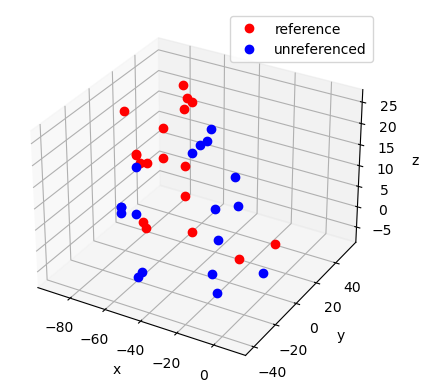

In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as LA
from squaternion import Quaternion
import matplotlib.pyplot as plt

# LIDAR adatok
dat = np.loadtxt('lidar.dat')

ref = dat[:,1:4]
unr = dat[:,4:]
npts = len(ref[:,0])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(ref[:,0], ref[:,1], ref[:,2], "ro", label="reference")
ax.plot(unr[:,0], unr[:,1], unr[:,2], "bo", label="unreferenced")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(loc="upper right")


Kiszámítjuk az $M$ mátrixot

In [2]:
# átlag eltávolítása
pm = np.mean(unr,axis=0)
qm = np.mean(ref,axis=0)
pv = unr-pm
qv = ref-qm

def quat2Q(q):
    Q = np.zeros((4,4))
    Q[1:,0] = np.array(q.vector)
    Q[2,1] =  q.z
    Q[3,1] = -q.y
    Q[3,2] =  q.x
    Q = Q - np.tril(Q).T
    return Q

def quat2P(p):
    P = np.zeros((4,4))
    P[1:,0] = np.array(p.vector)
    P[2,1] = -p.z
    P[3,1] =  p.y
    P[3,2] = -p.x
    P = P - np.tril(P).T
    return P

def v2q(v):
    q = Quaternion(0,v[0],v[1],v[2])
    return q

# M mátrix számítása
M = np.zeros((4,4))
for i in range(npts):
    pi = v2q(pv[i])
    qi = v2q(qv[i])
    Pi = quat2P(pi)
    Qi = quat2Q(qi)
    Mi = np.dot(Pi.T,Qi)
    M = M + Mi

Meghatározzuk az $M$ mátrix legnagyobb sajátértékéhez tartozó sajátvektort, ami az illesztéshez szükséges forgatási kvaternió.

In [3]:
w,v = LA.eig(M)

# max. sajátértékhez tartozó sajátvektor
i = np.argmax(w)
vmx = v[:,i]
qr = Quaternion(vmx[0],vmx[1],vmx[2],vmx[3])
print("forgatási kvaternió: ", qr)
# forgatási mátrix
r = np.array( qr.to_rot() )
print("forgatási mátrix: ")
for i in range(3):
    print("{:12.9f} {:12.9f} {:12.9f}".format(r[i,0],r[i,1],r[i,2]))

forgatási kvaternió:  Quaternion(w=-0.9611777758345228, x=0.03668139078696401, y=-0.10309160306701529, z=-0.2533059023963061)
forgatási mátrix: 
 0.850416482 -0.494507094  0.179595490
 0.479380921  0.868981191  0.122742098
-0.216761941 -0.018287252  0.976053194


A [Wang et al. (2014)](http://dx.doi.org/10.1016/j.isprsjprs.2014.04.013) cikkében található eredmények:
<div>
<img src="figs/results.png" width="900"/>
</div>

Most számítsuk ki a $k$ méretarányt és a $t$ eltolást.

In [4]:
# méretarány 
kn = 0
kd = 0
for i in range(npts):
    kni = np.dot(np.dot(qv[i,:],r),pv[i,:])
    kdi = np.dot(pv[i,:],pv[i,:])
    kn += kni
    kd += kdi
k = kn/kd
print("méretarány: {:.9f}".format(k))

# eltolás
t = qm - k*np.dot(r,pm)
print("eltolás: ")
print("{:8.4f} {:8.4f} {:8.4f}".format(t[0],t[1],t[2]))

méretarány: 1.000385442
eltolás: 
-22.9656  29.3962  -2.2652


Transzformáljuk a pontokat és nézzük meg, hogy illeszkednek-e?

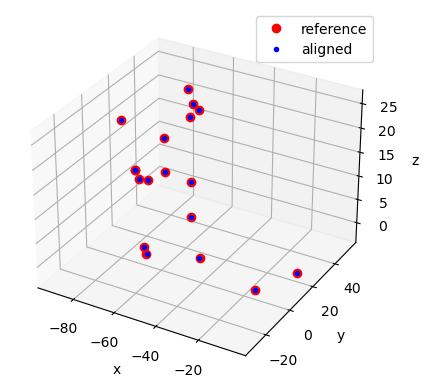

In [5]:
# transzformáció
trf = k*np.dot(r,unr.T).T + t

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(ref[:,0], ref[:,1], ref[:,2], "ro", label="reference")
ax.plot(trf[:,0], trf[:,1], trf[:,2], "bo", ms=3, label="aligned")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend(loc="upper right")

Számítsuk ki és rajzoljuk fel a pontonkénti lineáris eltéréseket!

Text(0, 0.5, 'eltérés (m)')

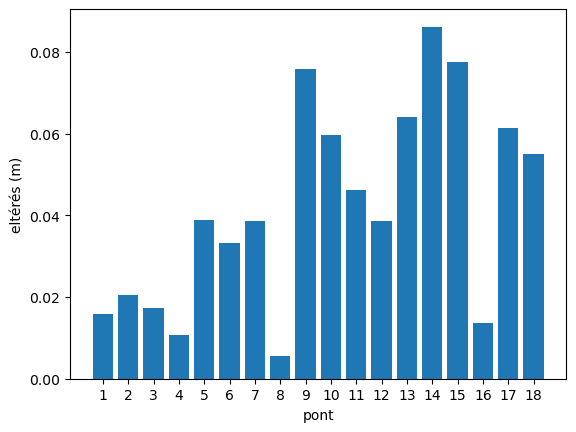

In [6]:
# maradékok
dr = trf-ref
dv = LA.norm(dr,axis=1)
pt = list(range(1,npts+1))
fig = plt.figure()
plt.bar(pt,dv)
plt.xticks(pt)
plt.xlabel('pont')
plt.ylabel('eltérés (m)')